<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep15-eda-modeling-submission?scriptVersionId=129855427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (05/15/2023)
    * EDA 
    * Baseline modeling 1.0
    
2. Version 2 (05/16/2023)
    * Baseline modeling 1.0 updated.
    
3. Version 3 (05/16/2023)
    * Baseline modeling 1.0 updated
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>        

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
data = pd.read_csv('../input/playground-series-s3e15/data.csv')
original = pd.read_csv('../input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv')
submission = pd.read_csv('../input/playground-series-s3e15/sample_submission.csv')

print('The dimension of the synthetic dataset is:', data.shape)
print('The dimension of the orginal dataset is:', original.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the synthetic dataset is: (31644, 10)
The dimension of the orginal dataset is: (1865, 10)
The dimension of the submission dataset is: (10415, 2)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [4]:
data.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [5]:
data.describe()

,id,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
count,31644.000000,27192.000000,26853.000000,21229.000000,26156.000000,27055.000000,26885.000000,31644.000000
mean,15821.500000,10.640747,3068.011023,-0.000453,8.629255,14.174330,832.987391,3.796985
std,9134.980296,4.333683,1777.032080,0.100911,5.185692,19.838489,672.299239,1.983991
min,0.000000,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,7910.750000,6.890000,1519.000000,-0.046600,5.000000,5.600000,318.000000,2.400000
50%,15821.500000,11.070000,2731.000000,0.003800,7.800000,10.000000,610.000000,3.400000
75%,23732.250000,13.790000,4069.000000,0.064800,10.800000,11.500000,914.000000,4.600000
max,31643.000000,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


From the above table, we see that there are several missing values in the competition data.

In [6]:
100*np.sum(data.isnull(), axis = 0) / data.shape[0]

id                      0.000000
author                 15.876627
geometry               17.380862
pressure [MPa]         14.069018
mass_flux [kg/m2-s]    15.140311
x_e_out [-]            32.913032
D_e [mm]               17.342940
D_h [mm]               14.501959
length [mm]            15.039186
chf_exp [MW/m2]         0.000000
dtype: float64

From the above, we see that at least 14% of the data is missing in each of the features of the competition data (except `chf_exp [MW/m2]`).

In [7]:
original.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [8]:
original.describe()

,id,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,933.000000,10.010949,2862.647721,0.016179,9.417212,16.167721,911.340483,3.854638
std,538.523444,4.282715,1656.412247,0.117575,6.333807,21.182870,726.718974,1.985535
min,1.000000,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,467.000000,6.890000,1519.000000,-0.048300,5.600000,5.600000,432.000000,2.400000
50%,933.000000,10.340000,2590.000000,0.024400,8.500000,10.300000,625.000000,3.500000
75%,1399.000000,13.790000,3933.000000,0.100600,11.100000,15.200000,1778.000000,4.800000
max,1865.000000,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values in the original dataset. However, there are several missing values in the competition data. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

First, we start by visualizing the variable of interest.

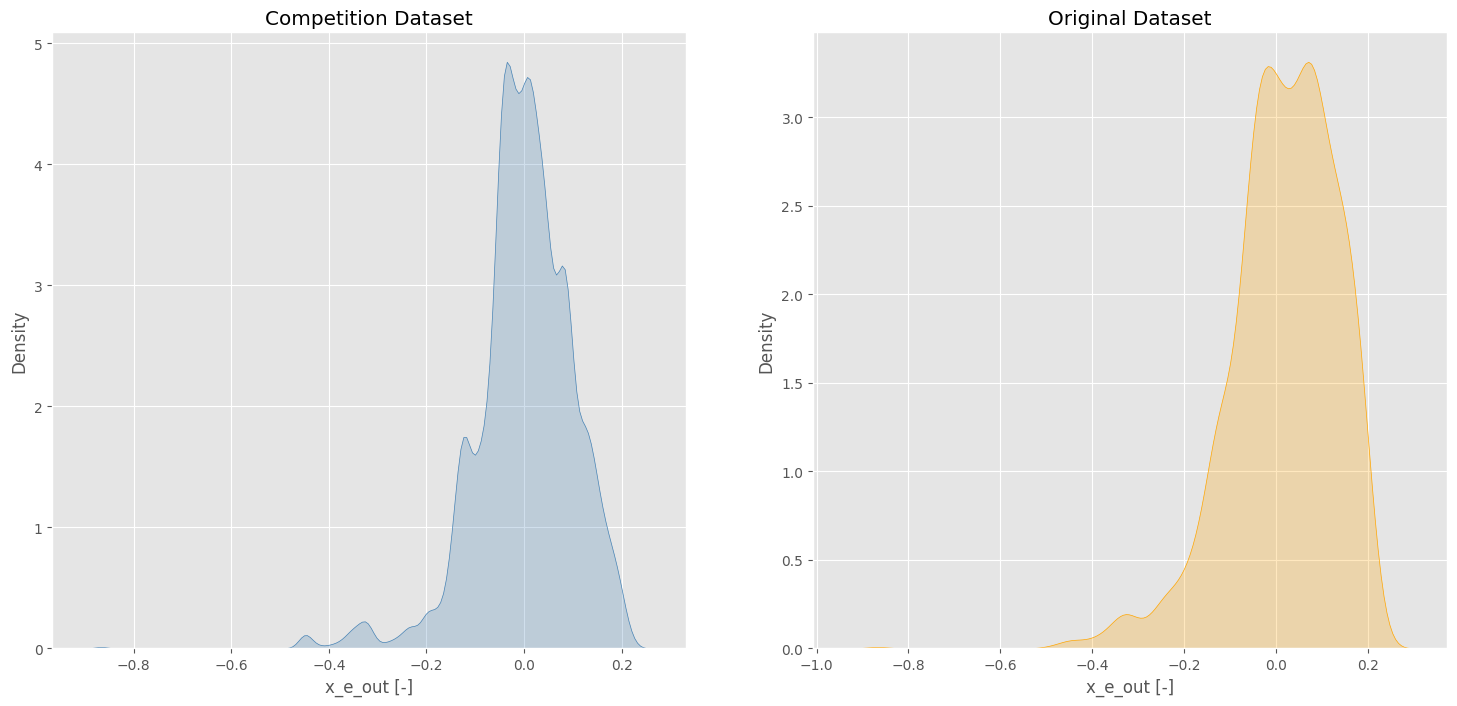

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.kdeplot(ax = axes[0], data = data, x = 'x_e_out [-]', fill = True, color = 'steelblue').set_title('Competition Dataset');
sns.kdeplot(ax = axes[1], data = original, x = 'x_e_out [-]', fill = True, color = 'orange').set_title('Original Dataset');

By a quick eye-ball test, the distribution of the variable of interest are approximately the same in the competition and original datasets. Next, we explore what features are related to the variable of interest.

/tmp/ipykernel_23/2464054138.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat_original = original.drop(columns = ['id'], axis = 1).corr()


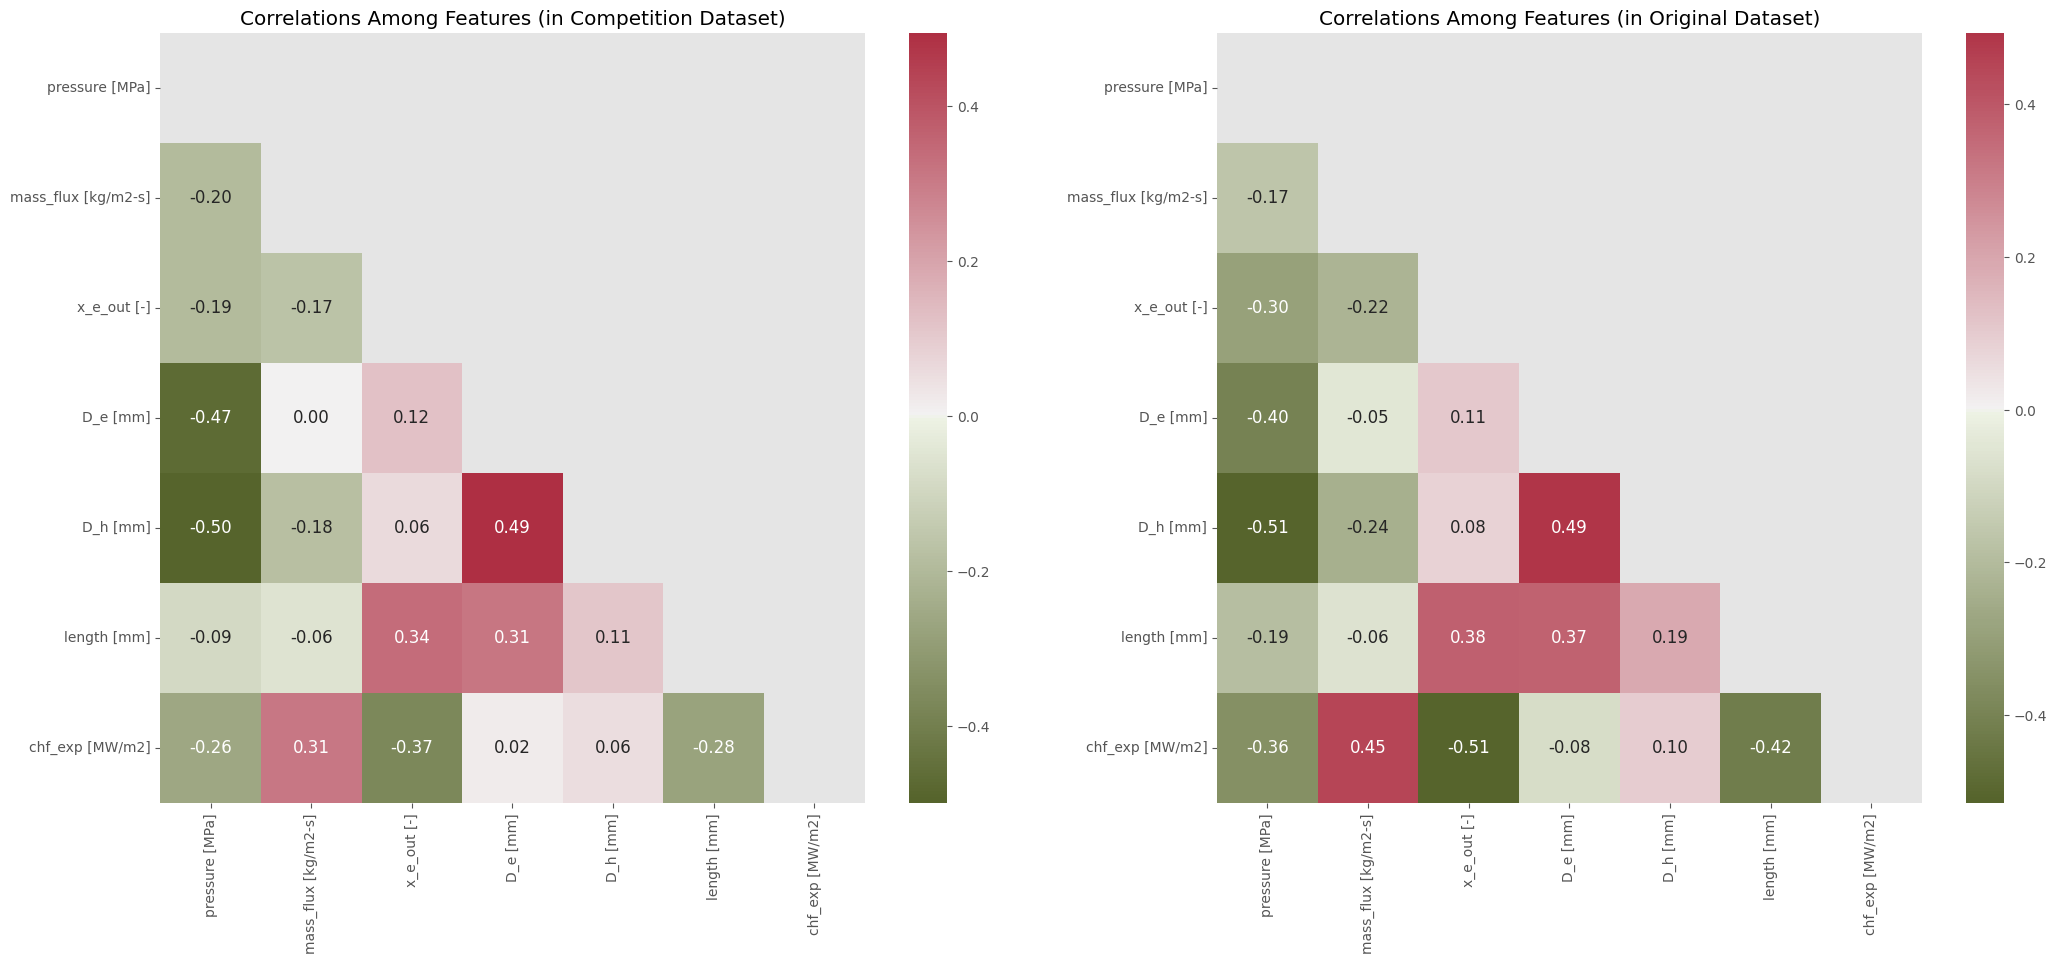

In [10]:
corr_mat_data = data.drop(columns = ['id', 'author', 'geometry'], axis = 1).corr()
corr_mat_original = original.drop(columns = ['id'], axis = 1).corr()

data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))
original_mask = np.triu(np.ones_like(corr_mat_original, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

fig, axes = plt.subplots(1, 2, figsize = (25, 10))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, ax = axes[0], mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)')
sns.heatmap(corr_mat_original, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, ax = axes[1], mask = original_mask).set_title('Correlations Among Features (in Original Dataset)');

From the above, `length [mm]` and `chf_exp [MW/m2]` correlated the most with `x_e_out [-]`. Note that this is consiistent in the competition and orginal datasets. Next we check for duplicates.

In [11]:
print('There are ', data.shape[0], 'observations in the competition dataset')
print('There are ', data.drop(columns = ['id', 'author', 'geometry'], axis = 1).drop_duplicates().shape[0], 'unique observations in the competition dataset')

There are  31644 observations in the competition dataset
There are  31140 unique observations in the competition dataset


In [12]:
print('There are ', original.shape[0], 'observations in the original dataset')
print('There are ', original.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], 'unique observations in the original dataset')

There are  1865 observations in the original dataset
There are  1816 unique observations in the original dataset


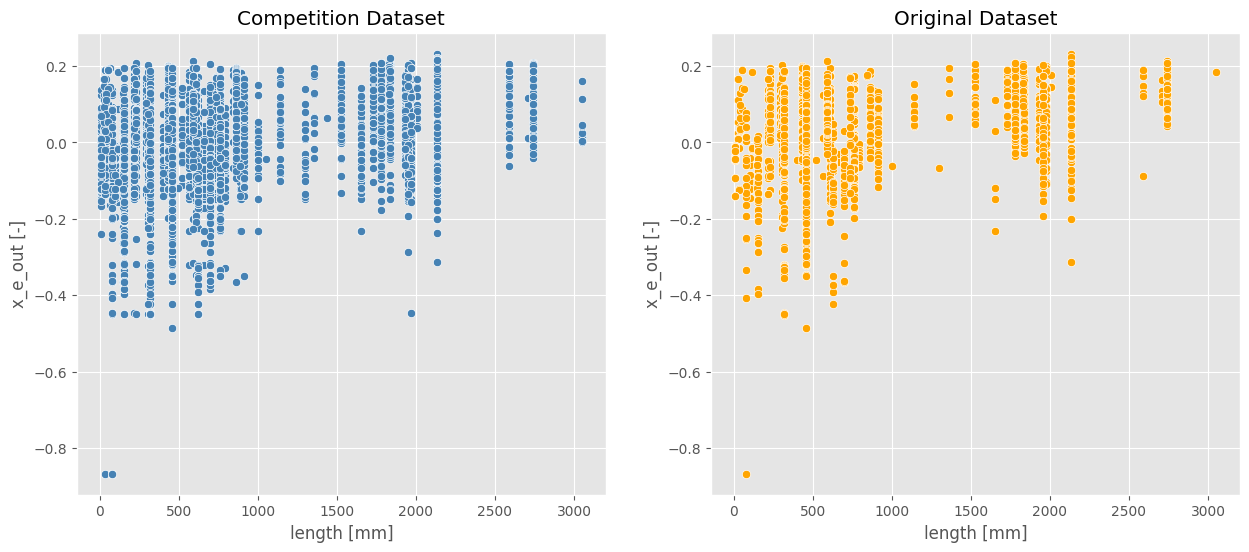

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = data, x = 'length [mm]', y = 'x_e_out [-]', color = 'steelblue').set_title('Competition Dataset')
sns.scatterplot(ax = axes[1], data = original, x = 'length [mm]', y = 'x_e_out [-]', color = 'orange').set_title('Original Dataset');

From the above plots, there seems to be a positive relationship between `length [mm]` and `x_e_out [-]`. 

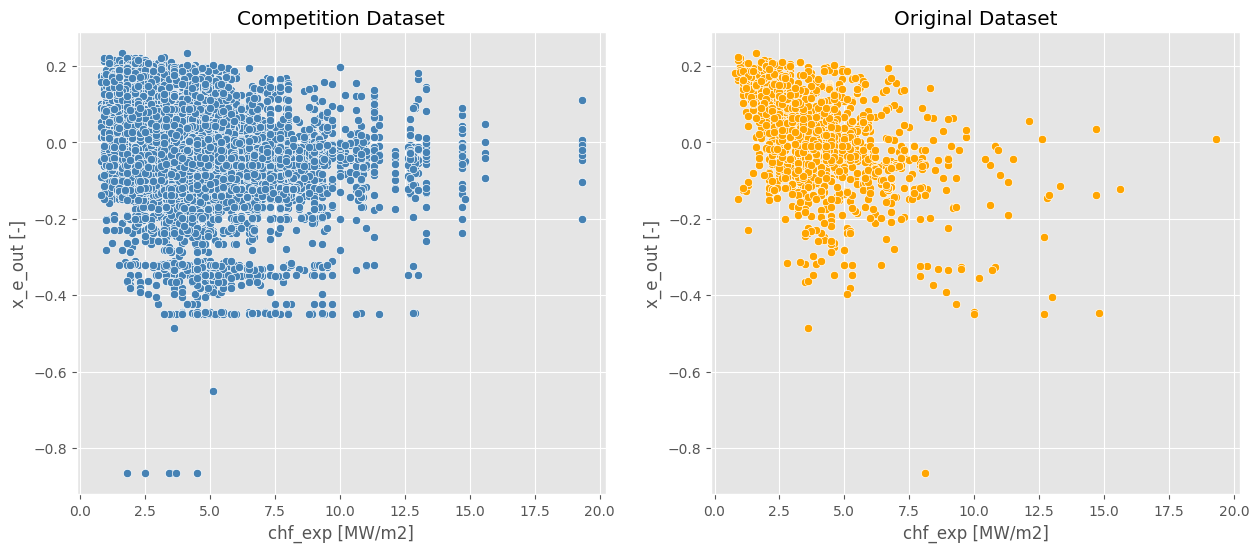

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = data, x = 'chf_exp [MW/m2]', y = 'x_e_out [-]', color = 'steelblue').set_title('Competition Dataset')
sns.scatterplot(ax = axes[1], data = original, x = 'chf_exp [MW/m2]', y = 'x_e_out [-]', color = 'orange').set_title('Original Dataset');

From the left plot (competition dataset), the relationship between `chf_exp [MW/m2]` and `x_e_out [-]` is not clear. However, in the right plot (original dataset), the relationship between `chf_exp [MW/m2]` and `x_e_out [-]` is more clear (negative).

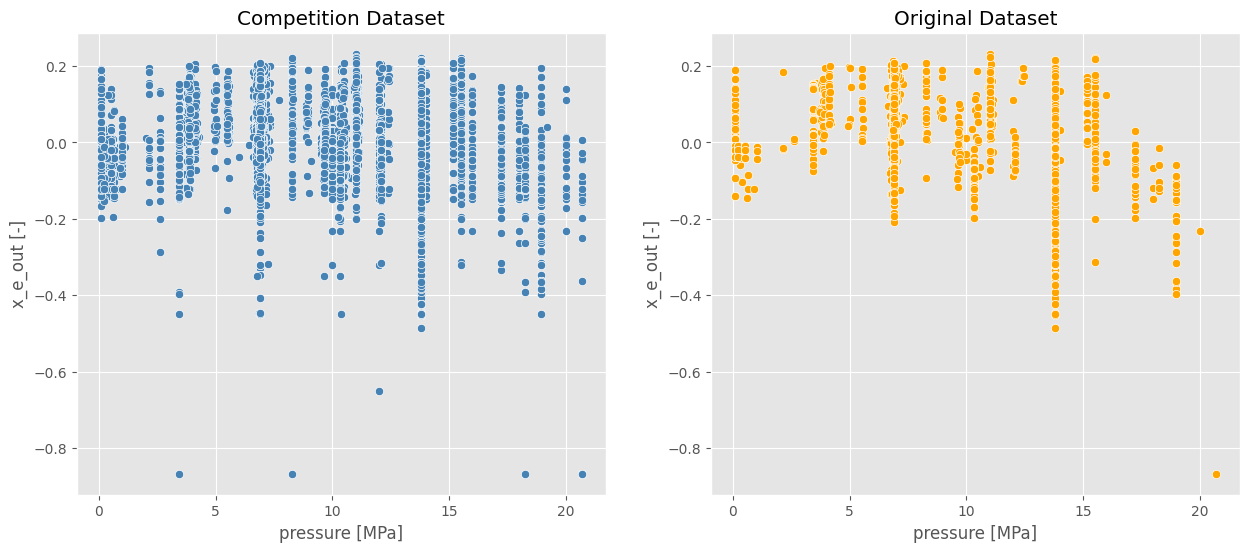

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = data, x = 'pressure [MPa]', y = 'x_e_out [-]', color = 'steelblue').set_title('Competition Dataset')
sns.scatterplot(ax = axes[1], data = original, x = 'pressure [MPa]', y = 'x_e_out [-]', color = 'orange').set_title('Original Dataset');

From the left plot (competition dataset), the relationship between `pressure [MPa]` and `x_e_out [-]` is not clear. However, in the right plot (original dataset), the relationship between `pressure [MPa]` and `x_e_out [-]` is a lite more clear (negative).

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

In [16]:
X = data[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'chf_exp [MW/m2]', 'length [mm]']].copy()
X['mass_flux_missing'] = np.where(X['mass_flux [kg/m2-s]'].isnull(), 1, 0)
X['pressure_missing'] = np.where(X['pressure [MPa]'].isnull(), 1, 0)
X['chf_missing'] = np.where(X['chf_exp [MW/m2]'].isnull(), 1, 0)
X['generated'] = 1

X_org = original[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'chf_exp [MW/m2]', 'length [mm]']].copy()
X_org['mass_flux_missing'] = np.where(X_org['mass_flux [kg/m2-s]'].isnull(), 1, 0)
X_org['pressure_missing'] = np.where(X_org['pressure [MPa]'].isnull(), 1, 0)
X_org['chf_missing'] = np.where(X_org['chf_exp [MW/m2]'].isnull(), 1, 0)
X_org['generated'] = 0

Y = data['x_e_out [-]']
Y_org = original['x_e_out [-]']

X = pd.concat([X, X_org], axis = 0).reset_index(drop = True)
Y = pd.concat([Y, Y_org], axis = 0).reset_index(drop = True)

X.columns = ['pressure', 'mass_flux', 'chf_exp', 'length', 'mass_flux_missing', 'pressure_missing', 'chf_missing', 'generated']

test = X[Y.isnull()]
X = X[~Y.isnull()]
Y = Y[~Y.isnull()]

hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
cat_cv_scores, cat_preds = list(), list()
ridge_cv_scores, ridge_preds = list(), list()

skf = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
    print('---------------------------------------------------------------')
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingRegressor(l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000, 
                                            max_depth = 8,   
                                            max_bins = 255, 
                                            min_samples_leaf = 20,  
                                            max_leaf_nodes = 50).fit(X_train, Y_train) 

    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test)

    hist_score_fold = mean_squared_error(Y_test[X_test['generated'] == 1], hist_pred_1, squared = False)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof RMSE is ==>', hist_score_fold)
    
    ##############
    ## LightGBM ##
    ##############
    
    lgb_md = LGBMRegressor(n_estimators = 1000, 
                           max_depth = 5,  
                           learning_rate = 0.01,
                           num_leaves = 50, 
                           min_child_samples = 20, 
                           reg_alpha = 0.01,  
                           reg_lambda = 0.01,
                           subsample = 0.7, 
                           colsample_bytree = 0.8, 
                           device = 'gpu').fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test)

    lgb_score_fold = mean_squared_error(Y_test[X_test['generated'] == 1], lgb_pred_1, squared = False)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof RMSE is ==>', lgb_score_fold)
    
    #############
    ## XGBoost ##
    #############
    
    xgb_md = XGBRegressor(tree_method = 'gpu_hist',
                          colsample_bytree = 0.8,  
                          gamma = 0.01, 
                          learning_rate = 0.01, 
                          max_depth = 5,  
                          min_child_weight = 50, 
                          n_estimators = 1000, 
                          subsample = 0.7).fit(X_train, Y_train) 
    
    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test)

    xgb_score_fold = mean_squared_error(Y_test[X_test['generated'] == 1], xgb_pred_1, squared = False)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof RMSE is ==>', xgb_score_fold)
    
    ##############
    ## CatBoost ##
    ##############
    
    cat_md = CatBoostRegressor(loss_function = 'RMSE',
                               iterations = 1000,
                               learning_rate = 0.01,
                               depth = 10,
                               random_strength = 0.5,
                               bagging_temperature = 0.7,
                               border_count = 55, 
                               l2_leaf_reg = 5, 
                               verbose = False, 
                               task_type = 'GPU').fit(X_train, Y_train)
    
    cat_pred_1 = cat_md.predict(X_test[X_test['generated'] == 1])
    cat_pred_2 = cat_md.predict(test)

    cat_score_fold = mean_squared_error(Y_test[X_test['generated'] == 1], cat_pred_1, squared = False)    
    cat_cv_scores.append(cat_score_fold)
    cat_preds.append(cat_pred_2)
    
    print('Fold', i, '==> CatBoost oof RMSE is ==>', cat_score_fold)
    
    ##############
    ## Ensemble ##
    ##############
    
    x = pd.DataFrame({'hist': hist_pred_1, 'lgb': lgb_pred_1, 'xgb': xgb_pred_1, 'cat': cat_pred_1})
    y = Y_test[X_test['generated'] == 1]
    
    ridge_cv = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 1], cv = 5).fit(x, y)
    alpha_cv = ridge_cv.alpha_
    
    ridge_md = Ridge(alpha = alpha_cv).fit(x, y)
    ridge_pred = ridge_md.predict(x)
    
    x_test = pd.DataFrame({'hist': hist_pred_2, 'lgb': lgb_pred_2, 'xgb': xgb_pred_2, 'cat': cat_pred_2})
    ridge_test_pred = ridge_md.predict(x_test)
    ridge_score = mean_squared_error(y, ridge_pred, squared = False)
    ridge_cv_scores.append(ridge_score)
    ridge_preds.append(ridge_test_pred)
    
    print('Fold', i, '==> Ridge ensemble oof RMSE is ==>', ridge_score)
    print('---------------------------------------------------------------')

---------------------------------------------------------------
Fold 0 ==> HistGradient oof RMSE is ==> 0.07616141556497452
Fold 0 ==> LightGBM oof RMSE is ==> 0.07643857151698008
Fold 0 ==> XGBoost oof RMSE is ==> 0.07659915549478617
Fold 0 ==> CatBoost oof RMSE is ==> 0.07729078432288972
Fold 0 ==> Ridge ensemble oof RMSE is ==> 0.07605749841230486
---------------------------------------------------------------
---------------------------------------------------------------
Fold 1 ==> HistGradient oof RMSE is ==> 0.07274869379774304
Fold 1 ==> LightGBM oof RMSE is ==> 0.07309527662448005
Fold 1 ==> XGBoost oof RMSE is ==> 0.07279911278991325
Fold 1 ==> CatBoost oof RMSE is ==> 0.07320159524680746
Fold 1 ==> Ridge ensemble oof RMSE is ==> 0.07250140534043137
---------------------------------------------------------------
---------------------------------------------------------------
Fold 2 ==> HistGradient oof RMSE is ==> 0.07443280120235034
Fold 2 ==> LightGBM oof RMSE is ==> 0.0752

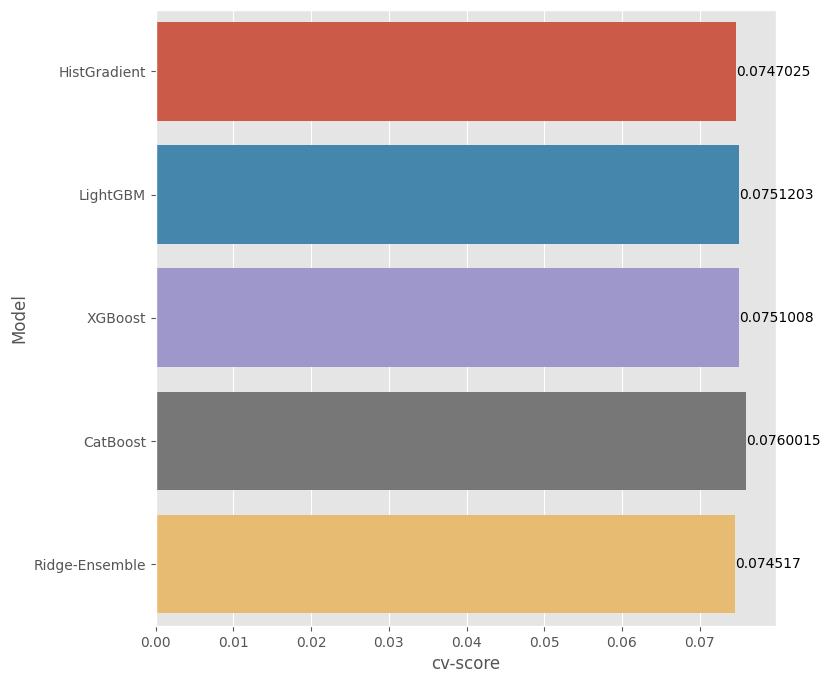

In [17]:
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
cat_cv_score = np.mean(cat_cv_scores)
ridge_cv_score = np.mean(ridge_cv_scores)

model_perf = pd.DataFrame({'Model': ['HistGradient' ,'LightGBM', 'XGBoost', 'CatBoost', 'Ridge-Ensemble'],
                           'cv-score': [hist_cv_score, lgb_cv_score, xgb_cv_score, cat_cv_score, ridge_cv_score]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);


In [18]:
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
cat_preds_test = pd.DataFrame(cat_preds).apply(np.mean, axis = 0)
ridge_preds_test = pd.DataFrame(ridge_preds).apply(np.mean, axis = 0)

submission['x_e_out [-]'] = hist_preds_test
submission.to_csv('Hist_Baseline_submission.csv', index = False)

submission['x_e_out [-]'] = lgb_preds_test
submission.to_csv('LightGBM_Baseline_submission.csv', index = False)

submission['x_e_out [-]'] = xgb_preds_test
submission.to_csv('XGBoost_Baseline_submission.csv', index = False)

submission['x_e_out [-]'] = cat_preds_test
submission.to_csv('CatBoost_Baseline_submission.csv', index = False)

submission['x_e_out [-]'] = ridge_preds_test
submission.to_csv('Ridge_Baseline_submission.csv', index = False)